Import packages

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
pd.plotting.register_matplotlib_converters()
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':90, 'font.size':9})

Import Financial Data and prepare datasets

In [2]:
symbols = {"BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"}

# Pull the data from January 2020 to current date
tickers = yf.Tickers(" ".join(symbols))

# Create a dictionary of Dataframes
hist = {}
for symbol in symbols:
    history = tickers.tickers[symbol].history(start="2020-01-01")
    history.rename(columns={'Open': 'y'}, inplace=True) # fbprophet will detect 'y' column
    history.index.rename('ds', inplace=True) # fbprophet will detect 'ds' dates
    history.reset_index(inplace=True) # Dates are now a column rather than an index (necessary with fbprophet)
    history['ds'] = history['ds'].dt.tz_localize(None)
    hist[symbol] = history

Define the object which will output BUY/SELL/HOLD recommandations based on a Univariate Time Series Forecasting

In [3]:
class recommender():
    ''' 
    Simulates trading of stocks based on the predictions of a statistical tool.
    
    Parameters
    ----------
    initial_stock: Initial stock owned in the simulation
    max_trade: Maximum number of stock units to be traded when a recommendation is made
    intensity: The quantity of stock traded per period is proportional to this parameter
    min_delta: Minimum predicted relative variation of the stock price to 
               recommend a BUY or SELL action.
               
    '''
    def __init__(self, initial_stock=100, max_trade = 100, intensity = 3, min_delta = 0.05):
        self.initial_stock = initial_stock
        self.max_trade = max_trade
        self.intensity = intensity*max_trade
        self.min_delta = min_delta
        
    def __call__(self, args):
        ''' 
        Performs a series of recommendations with the following procedure loop:
        
        1) Fits predictor to the data up to current_date from this iteration 
        2) Makes a prediction of the future stock price (after current_date)
            within a specified timeframe
        3) Makes a recommendation (BUY/SELL/HOLD) based on that prediction
        4) Updates current_date to the last date the prediction covered
    
        This sequence is looped up until a final date is reached.
            
        Parameters
        ----------
        history: 
            pd.DataFrame
            DataFrame with the timeseries data to learn from
        start_date:
            Minimum date up to which the predictor will be fitted
        end_date:
            Last date that the predictions extend to
        interval:
            Number of days separating each prediction point
        periods:
            Integer, predictor is re-fitted to the data up to current date 
            after every "periods" predictions
        
        Returns
        ----------
        A plot of the predictions compared to the real data, the financial
        balance resulting from applying the successive recommendations
        '''
        history, start_date, end_date, periods, interval = args
        
        ## Initiate all the relevant values
        # Basic attributes
        self.stock = self.initial_stock
        initial_price= float(history.loc[(history['ds']-start_date).abs().idxmin()]['y'])
        self.initial_value = self.initial_stock*initial_price # Value of Initial Stock
        self.gains = 0
        
        # Historical attributes
        self.value_history = [] # History of the variation of the value of stock being held
        self.gain_history = [] # History of gains resulting from each successive traded stock
        self.net_gain_history = [] # History of gains resulting from each successive traded stock 
                                    # net of that traded stock value at the next period
                                    # The net gain will be negative if the price of the stock sold increases 
                                    # or if the price of the stock bought decreases
        self.action_history = [] # History of each trading action performed
        
        # pre_pred will show how the predictor fits the data
        mask = history['ds']<start_date
        pre_pred = history[mask]
        self.predictions = pd.DataFrame(data = {'ds': pre_pred['ds'], 'y': pre_pred['y']})
        
        # Loop predictions until end_date
        current_date = start_date
        plt.figure()
        plt.axvline(start_date, color = 'b') # Data fitted up to that point
        while current_date < end_date:
            # Fit the predictor to the history of stock prices
            forecast, prediction, next_date = self.forecast(history, current_date, periods, interval)
            print(type(forecast))
            plt.axvline(next_date, color = 'g') # A green vertical line indicates that prediction was made at this date
            self.recommend(prediction, current_date, next_date)
            self.predictions = pd.concat([self.predictions, forecast], ignore_index = True)
            current_date = next_date
        current_price = float(history.loc[(history['ds']-current_date).abs().idxmin()]['y'])
        
        # Next, print all the relevant historical attributes from this recommender to analyze its performance
        self.totalvalue_history = [round(a+b,1) for a,b in zip(self.gain_history, self.value_history)]
        print(f'\nThe Wallet gains per trade is (positive values = SELL)\n{list(zip(self.action_history, self.gain_history))}')
        print(f'\nThe Stock Value gains per trade is\n{list(zip(self.action_history, self.value_history))}')
        print(f'\nStock + Wallet value variation after trading: \n{list(zip(self.action_history, self.totalvalue_history))}')
        print(f'\nStock + Wallet Gains related to stock traded: \n{list(zip(self.action_history, self.net_gain_history))}')
        print(f'with sum of {round(sum(self.net_gain_history), 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {start_date}: {round(self.initial_value, 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {end_date}: {round(self.initial_stock*current_price, 1)}')
        print(f'\nFinal stock (Quantity = {round(self.stock, 3)}) value on {end_date}: {round(self.value, 1)}')
        print(f'\nGains from trading: {round(self.gains, 1)}')
        print(f'\nBalance compared to initial stock value on {end_date} (value owned if no trading) = {round(self.gains + self.value - self.initial_stock*current_price,1)}')
        print(f'\nBalance compared to initial stock value on {start_date}: {round(self.gains + self.value - self.initial_value,1)}')
        
        # Plot the predictions compared to real data
        history = history[['ds', 'y']].set_index('ds').squeeze()
        self.predictions = self.predictions[['ds', 'y']].set_index('ds').squeeze()
        MAE, self.error = self.MAE(history, self.predictions, start_date, end_date)
        print(f'\n{MAE = }')
        rolling = history.rolling(20)
        mean, std = rolling.mean(), rolling.std()
        bolling_min = pd.Series(mean-2*std)
        bolling_max = pd.Series(mean+2*std)
        plt.title(f'Forecast and real data compared for {symbol}')
        plt.plot(self.predictions, color = 'g', label = 'Predictions')
        plt.plot(history, ':', color = 'k', label = 'History')
        plt.plot(bolling_min, color = 'b', label = 'Top of Bollinger Band')
        plt.plot(bolling_max, color = 'r', label = 'Bottom of Bollinger Band')
        plt.legend()
        plt.xlabel('Date')
        plt.xticks(fontsize = 8) 
        plt.ylabel('Open')
        plt.show()
        
    def recommend(self, prediction, current_date, next_date):
        '''
        Performs a recommendation based on the predictor's forecast
        
        Parameters
        ----------
        forecast: The forecast of future stock prices
        current_date: Initial date of the forecast
        next_date: Last date of the forecast
        '''
        current_price = float(history.loc[(history['ds']-current_date).abs().idxmin()]['y'])
        self.value = self.stock*current_price # Current stock value
        actual_next_price = float(history.loc[(history['ds']-next_date).abs().idxmin()]['y'])
        
        relative = (prediction-current_price)/current_price # Relative price change
        action = ["SELL", "BUY"]
        
        # Determine action to take based on predicted relative price change
        if abs(relative) >= self.min_delta:
            t = prediction/current_price
            sign = int(t>1/t) - int(t<1/t) # equals 1 if prediction>current_price, else -1
            trade = round(max(-self.stock, min(self.intensity*(max(t, 1/t)-1), self.max_trade)*sign), 6)
                # The amount of stock traded (self.intensity*(max(t, 1/t)-1)) 
                # is higher when a larger price change is predicted
            self.stock += trade
            self.gains -= trade*current_price
            self.net = trade*(actual_next_price-current_price)
            self.action_history.append(action[int(relative>0)]) # BUY or SELL
        else:
            self.net = 0
            self.action_history.append("HOLD")
            trade = 0
    
        # Update value of stock being held
        self.value_history.append(round(self.stock*actual_next_price - self.value,1))
        self.value = self.stock*actual_next_price # Updated stock value
        self.gain_history.append(round(-trade*current_price,1))
        self.net_gain_history.append(round(self.net, 1))
    
    def cross_validate(self):
        df_cv = cross_validation(predictor, 
                                 initial = '730 days', 
                                 period = '45 days', 
                                 horizon = '90 days',
                                 parallel = 'processes')
        df_cv.head()
    
    def forecast(self, history, current_date, periods, interval):
        mask = history['ds']<=current_date
        to_fit = history[mask][['ds', 'y']]
        predictor = Prophet()
        predictor.fit(to_fit) 
        # Predictor is now fitted to data prior to current_date
        freq_dict = {1:"d", 7:"w", 30:"m", 90: 'Q'}
        future = predictor.make_future_dataframe(periods = periods, 
                                                 freq = freq_dict[interval], 
                                                 include_history = False)
        forecast = predictor.predict(future)
        forecast.rename(columns={'yhat': 'y'}, inplace = True)
        prediction = forecast['y'].iloc[-1] # Predicted future stock price
        next_date = forecast['ds'].iloc[-1]
        return forecast, prediction, next_date

    def MAE(self, history, forecast, start_date, end_date):
        '''Returns the Mean Absolute Error of the forecast'''
        hmask = (history.index >= start_date) & (history.index <= end_date)
        fmask = (forecast.index >= start_date) & (forecast.index <= end_date)
        error = history[hmask].subtract(forecast[fmask]).abs().dropna()
        return round(error.mean(), 1), error

In [4]:
plt.rcParams.update({'figure.figsize':(14,8), 'figure.dpi':90, 'font.size':7})

Choose what to forecast

In [5]:
symbols = ["BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"]
symbol = symbols[0]
history = hist[symbol]

Set the time parameters

In [6]:
start_date = pd.to_datetime('2022-05-01') # Predictions begin after this date
end_date = pd.to_datetime('2023-10-25') # Predictions end after this date

interval = 30 # in days
periods = 1 # A recommendation is made every periods*interval days

Set the stock parameters

In [7]:
initial_stock = 10
max_trade = 10 # Maximum units of stock that can be traded after 1 recommendation is made
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_delta = 0.05 # Minimum predicted relative variation of stock price to perform a SELL or BUY action (0<min_delta<1)

Create a recommender object

In [8]:
recommend = recommender(initial_stock = initial_stock, 
                        max_trade = max_trade,
                        intensity = intensity,
                        min_delta = min_delta)

Perform the recommendation

12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:23 - cmdstanpy - INFO - Chain [1] start processing
12:37:23 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:24 - cmdstanpy - INFO - Chain [1] start processing
12:37:24 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:27 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:28 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:28 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:33 - cmdstanpy - INFO - Chain [1] start processing
12:37:34 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:35 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>

The Wallet gains per trade is (positive values = SELL)
[('SELL', 377132.7), ('SELL', 0.0), ('BUY', -58579.0), ('HOLD', 0.0), ('SELL', 57679.6), ('BUY', -64210.7), ('SELL', 67688.9), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', -47674.8), ('SELL', 56816.7), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', -272052.5), ('BUY', -81924.8), ('BUY', -241189.0)]

The Stock Value gains per trade is
[('SELL', -377132.7), ('SELL', 0.0), ('BUY', 68902.5), ('HOLD', -11223.0), ('SELL', -57679.6), ('BUY', 67688.9), ('SELL', -67688.9), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', 56816.7), ('SELL', -56816.7), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', 253688.0), ('BUY', 77127.8), ('BUY', 402479.3)]

Stock + Wallet value variation after trading: 
[('SELL', 0.0), ('SELL', 0.0), ('BUY', 10323.5), ('HOLD', -11223.0), ('SELL', 0.0), ('BUY', 3478.2), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', 9141.9), ('SELL', 0.0)

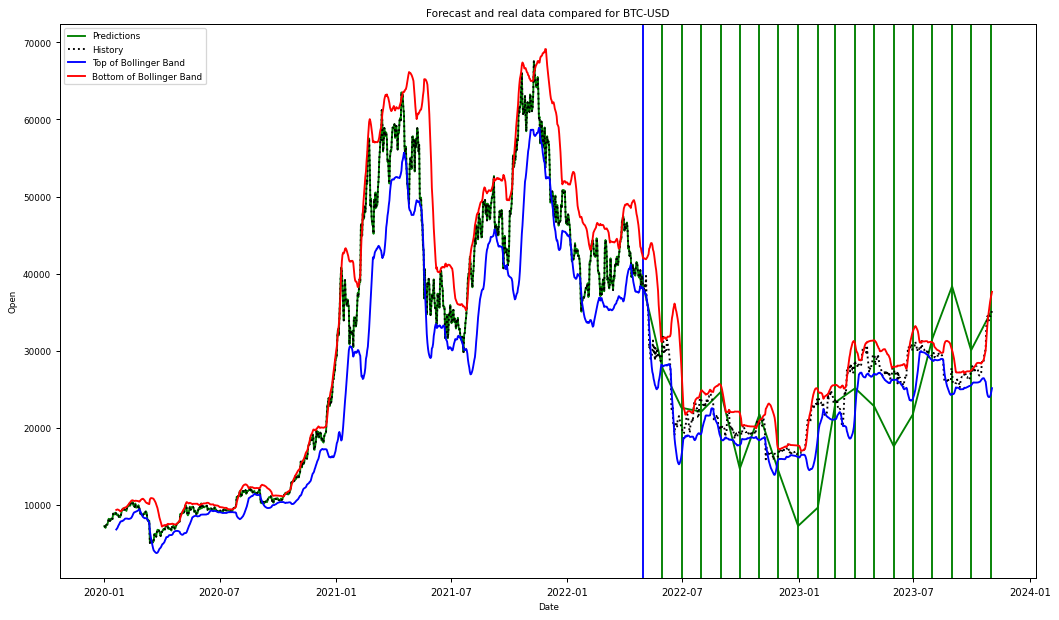

In [9]:
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation

Reset the time parameters to a smaller interval

In [10]:
interval = 7 # in days
periods = 2 # A recommendation is made every periods*interval days

Perform the recommendation

12:37:38 - cmdstanpy - INFO - Chain [1] start processing
12:37:39 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:39 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:41 - cmdstanpy - INFO - Chain [1] start processing
12:37:41 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:41 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:44 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:45 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:45 - cmdstanpy - INFO - Chain [1] start processing
12:37:45 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:46 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:47 - cmdstanpy - INFO - Chain [1] start processing
12:37:47 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:47 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:49 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:49 - cmdstanpy - INFO - Chain [1] start processing
12:37:50 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:50 - cmdstanpy - INFO - Chain [1] start processing
12:37:51 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:51 - cmdstanpy - INFO - Chain [1] start processing
12:37:51 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:53 - cmdstanpy - INFO - Chain [1] start processing
12:37:53 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:56 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:58 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:02 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:03 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:05 - cmdstanpy - INFO - Chain [1] start processing
12:38:05 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:09 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:10 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>

The Wallet gains per trade is (positive values = SELL)
[('SELL', 90766.6), ('SELL', 161052.1), ('SELL', 65074.9), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('BUY', -81573.9), ('BUY', -34931.1), ('SELL', 103190.4), ('SELL', 0.0), ('BUY', -69881.8), ('BUY', -107131.2), ('SELL', 46301.9), ('SELL', 55937.1), ('SELL', 60635.4), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', -132382.5), ('BUY', -223867.6), ('BUY', -207758.8), ('BUY', -128246.1), ('BUY', -54840.7), ('BUY', -153394.5), ('BUY', -220386.5)]

The Stock Value gains per trade is
[('SELL', -148586.7), ('SELL', -163471.1), ('SELL', -65074.9), ('SELL', -0.0), ('SELL', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('BUY', 75168.6), ('BUY', 28021.8), ('SELL', -103190.4), ('SELL', -0.0), ('BUY'

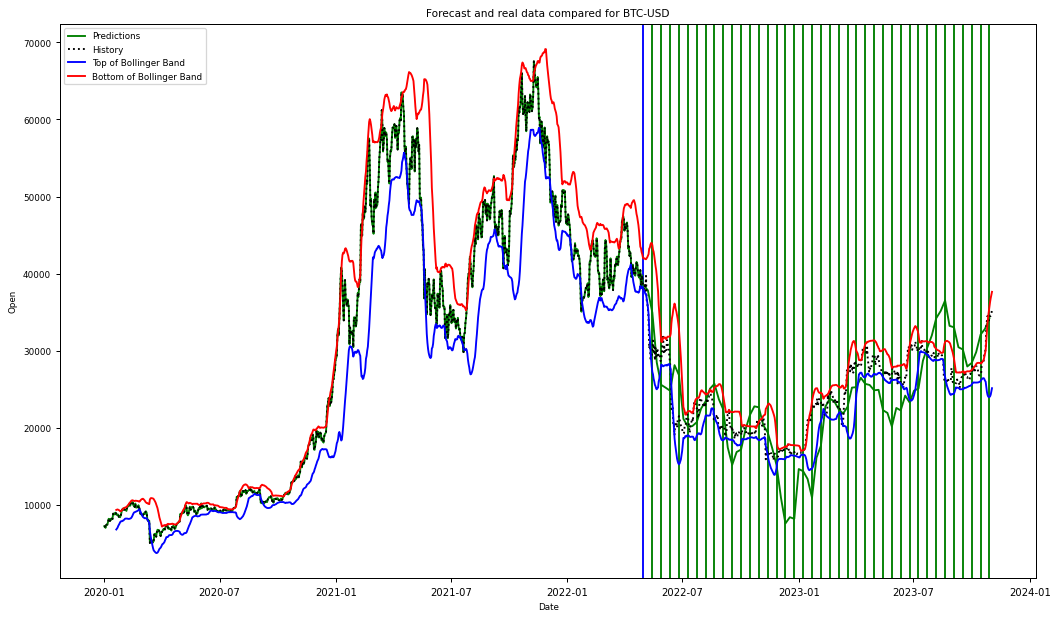

In [11]:
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation

Reset the stock parameters

In [12]:
initial_stock = 10
max_trade = 1 # Maximum units of stock that can be traded after 1 recommendation is made
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_delta = 0.05 # Minimum predicted relative variation of stock price to perform a SELL or BUY action (0<min_delta<1)

Create a recommender object

In [13]:
recommend = recommender(initial_stock = initial_stock, 
                        max_trade = max_trade,
                        intensity = intensity,
                        min_delta = min_delta)

Perform the recommendation

12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:17 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:19 - cmdstanpy - INFO - Chain [1] start processing
12:38:19 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:23 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:25 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:30 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:30 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:32 - cmdstanpy - INFO - Chain [1] start processing
12:38:32 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:34 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:37 - cmdstanpy - INFO - Chain [1] start processing
12:38:37 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:39 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:40 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:45 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>


12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing


<class 'pandas.core.frame.DataFrame'>

The Wallet gains per trade is (positive values = SELL)
[('SELL', 9076.6), ('SELL', 16105.2), ('SELL', 14890.6), ('SELL', 4952.6), ('SELL', 4330.9), ('HOLD', 0.0), ('HOLD', 0.0), ('BUY', -8157.4), ('BUY', -3493.1), ('SELL', 18329.7), ('SELL', 10472.3), ('BUY', -6988.2), ('BUY', -10713.1), ('SELL', 4630.2), ('SELL', 5593.7), ('SELL', 16463.9), ('SELL', 17129.7), ('SELL', 8836.9), ('SELL', 16954.1), ('SELL', 19880.9), ('HOLD', 0.0), ('SELL', 7444.3), ('HOLD', 0.0), ('SELL', 5506.6), ('SELL', 9249.6), ('SELL', 20033.3), ('SELL', 27557.4), ('SELL', 25382.0), ('SELL', 0.0), ('SELL', 0.0), ('SELL', 0.0), ('HOLD', 0.0), ('BUY', -13238.2), ('BUY', -22386.8), ('BUY', -20775.9), ('BUY', -12824.6), ('BUY', -5484.1), ('BUY', -15339.5), ('BUY', -22038.7)]

The Stock Value gains per trade is
[('SELL', -83390.8), ('SELL', -26055.6), ('SELL', -20521.0), ('SELL', -63658.8), ('SELL', -3542.5), ('HOLD', 7288.5), ('HOLD', 4150.9), ('BUY', -7512.3), ('BUY', -8266.2), (

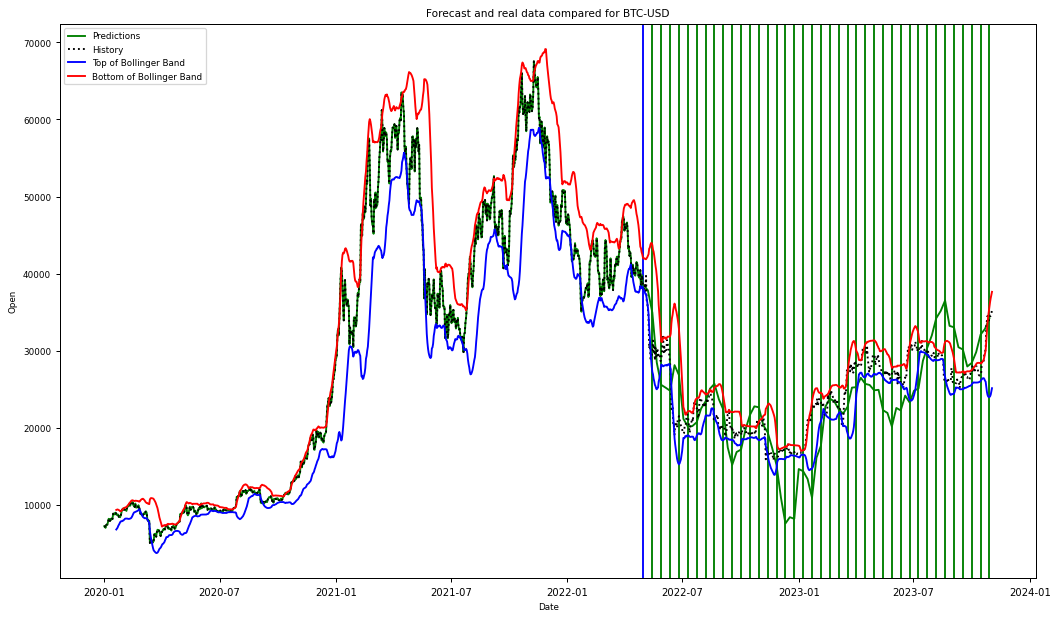

In [14]:
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation